# Twitter Sentiment Analysis

by match1

## Overview

#### About the Dataset:
Dataset Link (Kaggle): [Twitter-Sentiment-Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data)

<i>"This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral."</i>


#### About the Twitter Sentiment Analysis
<b>Highest Accuracy Score</b>: 93.2% (Random Forest model)

This notebook conducts Twitter sentiment analysis using machine learning. It includes data exploration, text preprocessing, and the training/testing of four models (Random Forest, KNN, Passive Aggressive Classifier, and Logistic Regression).

The aim is to determine the best model for predicting sentiment labels (Positive, Negative, Neutral, Irrelevant) from tweets (considering both accuracy and computational efficiency).

### Import Necessary Modules

In [718]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import time

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\misyel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\misyel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\misyel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading The Dataset

In [719]:
columns = ["id", "topic", "label", "text"]

# Load taining and validation dataset
df_train = pd.read_csv('../data/twitter_training.csv', names = columns, encoding='ISO-8859-1')
df_val = pd.read_csv('../data/twitter_validation.csv', names = columns, encoding='ISO-8859-1')

# Concatenate data
df = pd.concat([df_train, df_val], ignore_index=True)
df.head()

,id,topic,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [720]:
df.shape

(75682, 4)

In [721]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      75682 non-null  int64 
 1   topic   75682 non-null  object
 2   label   75682 non-null  object
 3   text    74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [722]:
df.label.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [723]:
df.isna().sum()

id         0
topic      0
label      0
text     686
dtype: int64

In [724]:
df = df.dropna()
df.isna().sum()

id       0
topic    0
label    0
text     0
dtype: int64

In [725]:
# Show count of each label
label_value_counts = df['label'].value_counts()
label_value_counts

label
Negative      22624
Positive      20932
Neutral       18393
Irrelevant    13047
Name: count, dtype: int64

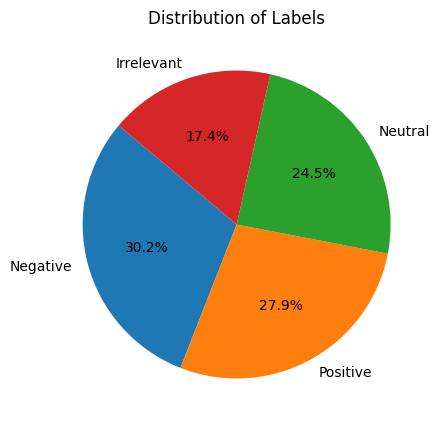

In [726]:
#  Plot pie chart to show proportions of label
plt.figure(figsize=(5, 5))
plt.pie(label_value_counts, labels=label_value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.show()

### Data Preprocessing

- lowercase
- remove URLs, mentions, hashtags, numbers, punctuations, and other non-word characters
- strip leading and trailing whitespace
- tokenize
- remove stop words and lemmatize

In [727]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stop words
stop_words = set(stopwords.words('english'))

# Add custom stop words
custom_stopwords = ['im', 'â', 'iâm']
stop_words.update(custom_stopwords)

# Preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove URLs, mentions, hashtags, numbers, punctuations, and other non-word characters (special characters)
    text = re.sub(r'http\S+|www\S+|https\S+|@\S+|#\S+|\d+|[^\w\s]', '', text, flags=re.MULTILINE)

    # Strip leading and trailing whitespace
    text = text.strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words and words with non-alphabetical characters, & lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    
    # Join tokens back to string
    processed_text = ' '.join(tokens)
    
    # Check if the processed text is empty or contains only whitespace
    if processed_text.strip() == '':
        return None
    
    return processed_text

# Apply the preprocessing function to the text column
df['text'] = df['text'].apply(preprocess_text)

In [728]:
df['text'].head(13)

0                             getting borderland murder
1                                    coming border kill
2                               getting borderland kill
3                              coming borderland murder
4                             getting borderland murder
5                             getting borderland murder
6     spent hour making something fun dont know huge...
7     spent couple hour something fun dont know huge...
8     spent hour something fun dont know huge border...
9     spent hour making something fun dont know huge...
10    spent hour making something fun dont know huge...
11                                                 None
12    rockhard la varlope rare powerful handsome jac...
Name: text, dtype: object

Remove rows with empty text

In [729]:
df.isna().sum()

id          0
topic       0
label       0
text     1716
dtype: int64

In [730]:
df = df.dropna(subset=['text'])
df.reset_index(drop=True, inplace=True)
df.head(13)

,id,topic,label,text
0,2401,Borderlands,Positive,getting borderland murder
1,2401,Borderlands,Positive,coming border kill
2,2401,Borderlands,Positive,getting borderland kill
3,2401,Borderlands,Positive,coming borderland murder
4,2401,Borderlands,Positive,getting borderland murder
5,2401,Borderlands,Positive,getting borderland murder
6,2402,Borderlands,Positive,spent hour making something fun dont know huge...
7,2402,Borderlands,Positive,spent couple hour something fun dont know huge...
8,2402,Borderlands,Positive,spent hour something fun dont know huge border...
9,2402,Borderlands,Positive,spent hour making something fun dont know huge...


In [731]:
df.isna().sum()

id       0
topic    0
label    0
text     0
dtype: int64

In [732]:
df['text'].duplicated().sum()

np.int64(10798)

In [733]:
df = df.drop_duplicates(subset=['text'])
df.reset_index(drop=True, inplace=True)
df.head()

,id,topic,label,text
0,2401,Borderlands,Positive,getting borderland murder
1,2401,Borderlands,Positive,coming border kill
2,2401,Borderlands,Positive,getting borderland kill
3,2401,Borderlands,Positive,coming borderland murder
4,2402,Borderlands,Positive,spent hour making something fun dont know huge...


### Exploratory Data Analysis

Which words appear the most per positive, negative, and neutral tweets?

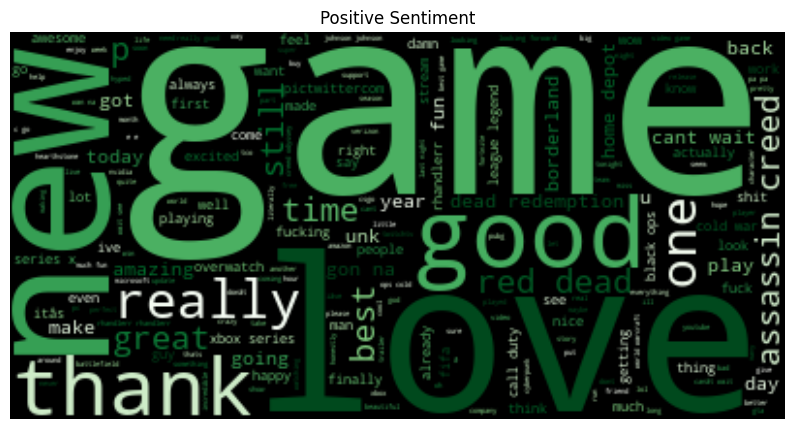

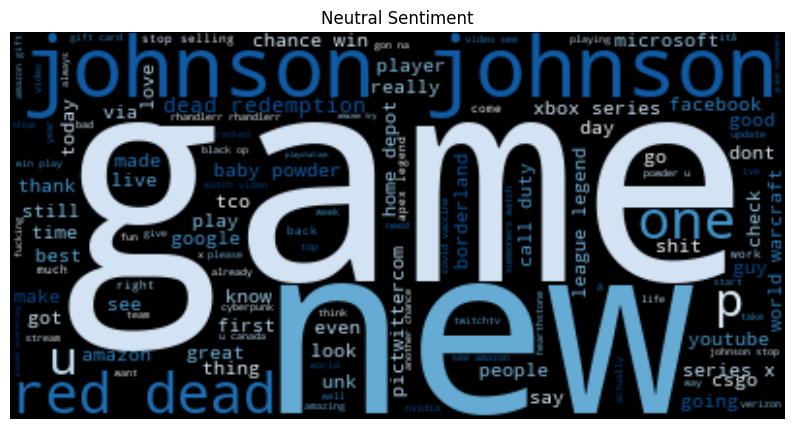

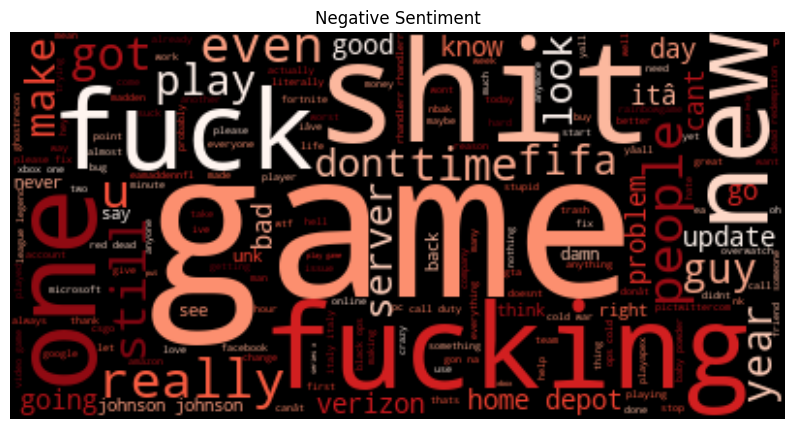

In [734]:
# Function to generate and display word cloud
def generate_word_cloud(text, title, colormap):
    wordcloud = WordCloud(background_color='black', colormap=colormap).generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Filter and concatenate text for positive, neutral, and negative labels
positive_text = ' '.join(df[df['label'] == 'Positive']['text'].dropna().astype(str).tolist())
neutral_text = ' '.join(df[df['label'] == 'Neutral']['text'].dropna().astype(str).tolist())
negative_text = ' '.join(df[df['label'] == 'Negative']['text'].dropna().astype(str).tolist())

# Generate and display word clouds with different color maps
generate_word_cloud(positive_text, 'Positive Sentiment', 'Greens')
generate_word_cloud(neutral_text, 'Neutral Sentiment', 'Blues')
generate_word_cloud(negative_text, 'Negative Sentiment', 'Reds')

Which topics have more Tweets?

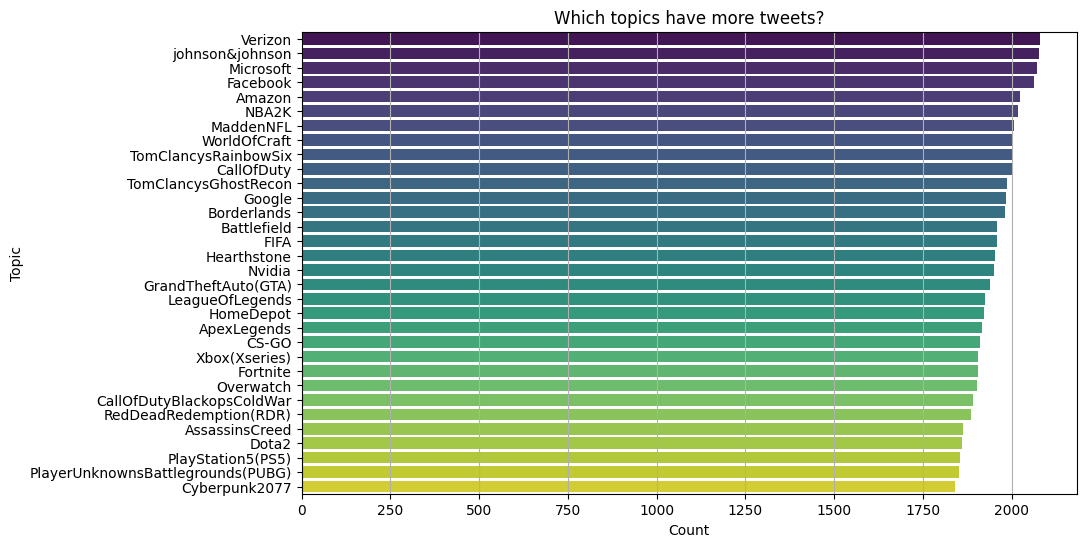

In [735]:
topic_value_counts = df["topic"].value_counts().reset_index()
topic_value_counts.columns = ['topic', 'count']
topic_value_counts = topic_value_counts.sort_values(by='count', ascending=False)

# Create the bar plot with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='count', y='topic', hue='topic', data=topic_value_counts, palette='viridis', dodge=False, legend=False)
plt.xlabel('Count')
plt.ylabel('Topic')
plt.title('Which topics have more tweets?')
plt.grid(axis='x')

plt.show()

Which topics have the most positive, negative, and neutral tweets?

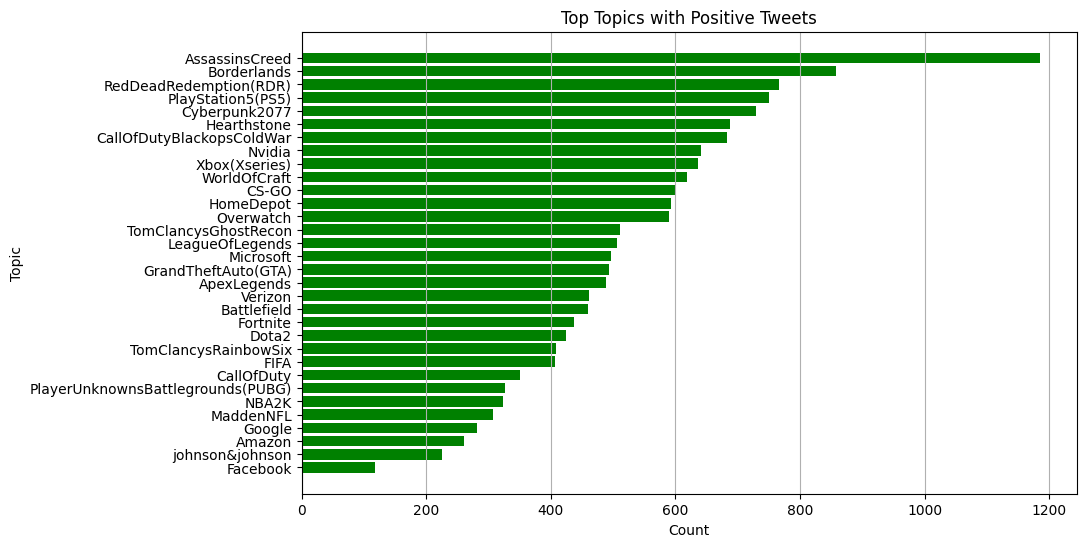

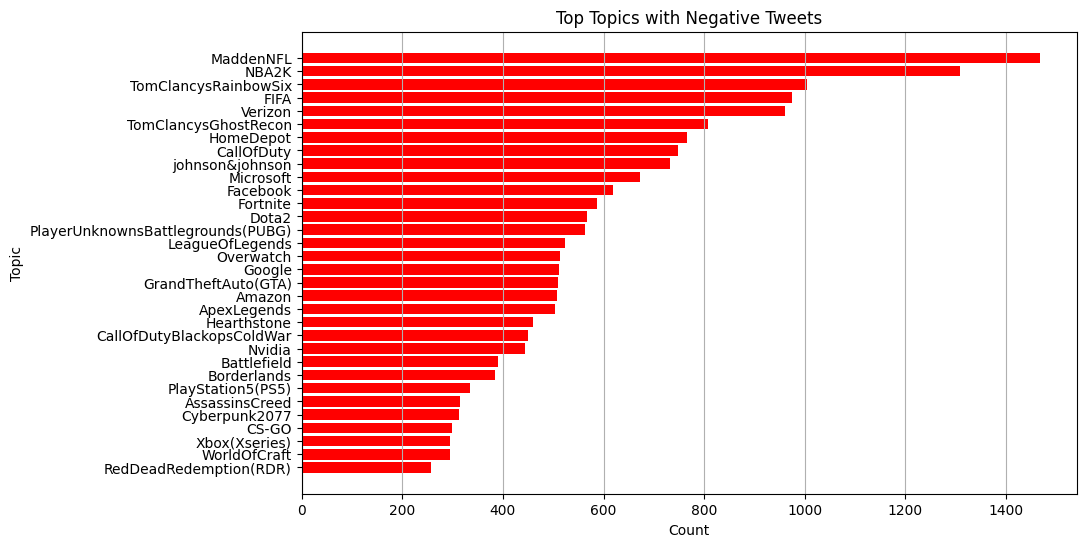

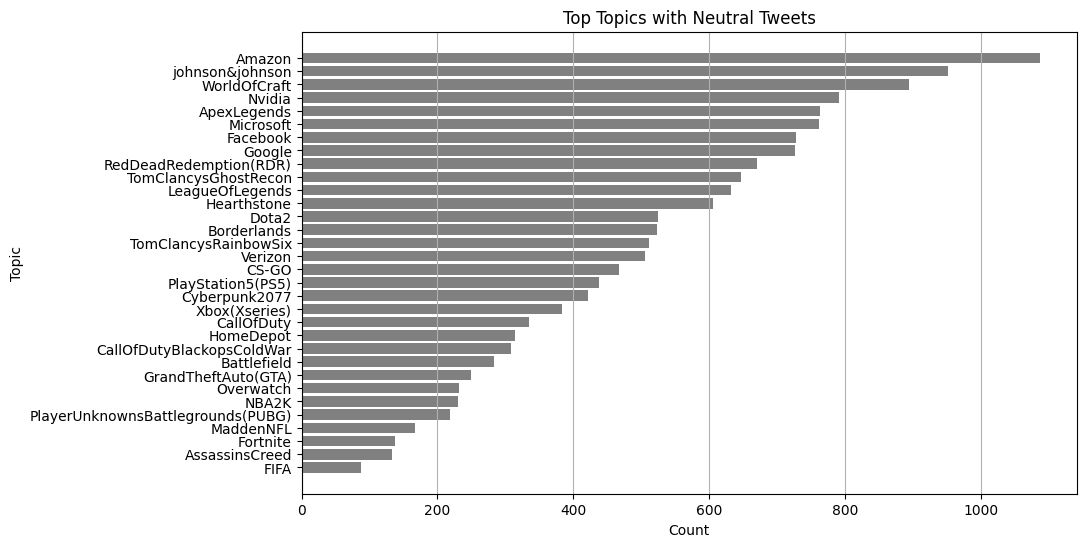

In [736]:
def plot_sentiment_topics(df, sentiment_label):
    # Group by topic and label, and count the occurrences
    df_count = df.groupby(['topic', 'label']).size().reset_index(name='count')

    # Filter rows where label matches the specified sentiment_label
    df_filtered = df_count[df_count['label'] == sentiment_label]

    # Sort the df by count
    df_filtered = df_filtered.sort_values(by='count', ascending=True)

    # Define colors based on sentiment
    colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'grey'}

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(df_filtered['topic'], df_filtered['count'], color=colors[sentiment_label])
    plt.xlabel('Count')
    plt.ylabel('Topic')
    plt.title(f'Top Topics with {sentiment_label} Tweets')
    plt.grid(axis='x')
    plt.show()

# Call the function for each sentiment label
plot_sentiment_topics(df, 'Positive')
plot_sentiment_topics(df, 'Negative')
plot_sentiment_topics(df, 'Neutral')


### Feature Engineering

Label Encoding

In [737]:
# Positive = 3
# Neutral = 2
# Negative = 1
# Irrelevant = 0

le_model = LabelEncoder()
df['label'] = le_model.fit_transform(df['label'])

Merge topic and text columns

Merging the "topic" and "text" columns helps the model understand tweets better by providing additional context. For example, if a tweet says "Assassin's Creed is great" and another says "Assassin's Creed is bad," just looking at the text might be confusing. But if we know the first tweet is about positive sentiments towards "Assassin's Creed" and the second is negative, the model can learn these differences more accurately.

In [738]:
df['combined_text'] = df['text'] + ' ' + df['topic']

### set X and y

In [739]:
X= df['combined_text']
y= df['label']

### Vectorize Text

In [740]:
vectorizer = TfidfVectorizer(max_features=10000)

# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

# Apply vectorizer for X
X = vectorizer.fit_transform(X)

### Split Data

In [741]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=df['label'])

In [742]:
print("X_train dimension:", X_train.shape)
print("X_test dimension:", X_test.shape)

X_train dimension: (49985, 10000)
X_test dimension: (12497, 10000)


### Building the Models

Function to measure training time and accuracy per model

In [743]:
def train_and_eval(model, X_train, y_train, X_test, y_test):
    # Measure start time
    start_time = time.time()
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Measure end time
    end_time = time.time()
    
    # Calculate training time
    training_time = end_time - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return training_time, accuracy

### Defining the models

1. <b>Random Forest</b>- is a machine learning method that creates many decision trees during training. It then combines the results of these trees to make a final prediction. This approach helps to avoid overfitting and improves the accuracy of the model.

2. <b>K-Nearest Neighbors</b>- is a simple, non-parametric classification algorithm that classifies data points based on the classes of their nearest neighbors. It looks at the closest data points (neighbors) to determine what class a new data point belongs to.

3. <b>Passive Aggressive Classifier</b>- is an online learning algorithm used for large-scale learning tasks. It updates its model only when it makes a wrong prediction (aggressive) and leaves it unchanged when the prediction is correct (passive). It is particularly suited for text classification tasks.

4. <b>Logistic Regression</b>- is a linear model for binary classification that estimates the probability that a given input belongs to a certain class. It uses the logistic function to model a binary dependent variable, making it useful for predicting categorical outcomes.

In [744]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Passive Aggressive': PassiveAggressiveClassifier(C=1.0, loss='hinge', tol=1e-3, max_iter=500, fit_intercept=True, random_state=42),
    'Logistic Regression': LogisticRegression(penalty=None,solver='sag',max_iter=500)
}

### Train and evaluate each model

In [745]:
results = []

# Train and evaluate each model
for model_name, model in models.items():
    training_time, accuracy = train_and_eval(model, X_train, y_train, X_test, y_test)
    results.append({
        'Model': model_name,
        'Training Time (seconds)': training_time,
        'Accuracy': accuracy
    })


results_df = pd.DataFrame(results)

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Model Evaluation

Compare Training Time of each model

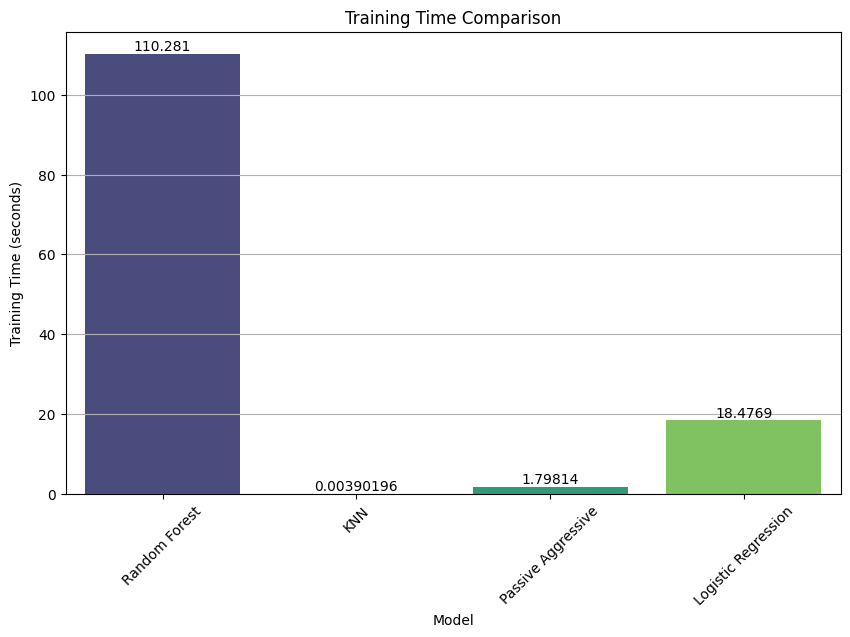

In [746]:
# Plot training time
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Model', y='Training Time (seconds)', hue='Model', data=results_df, palette='viridis', dodge=False, legend=False)
plt.title('Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add values per bar
for container in ax1.containers:
    ax1.bar_label(container)

plt.show()

Compare Accuracy of each model

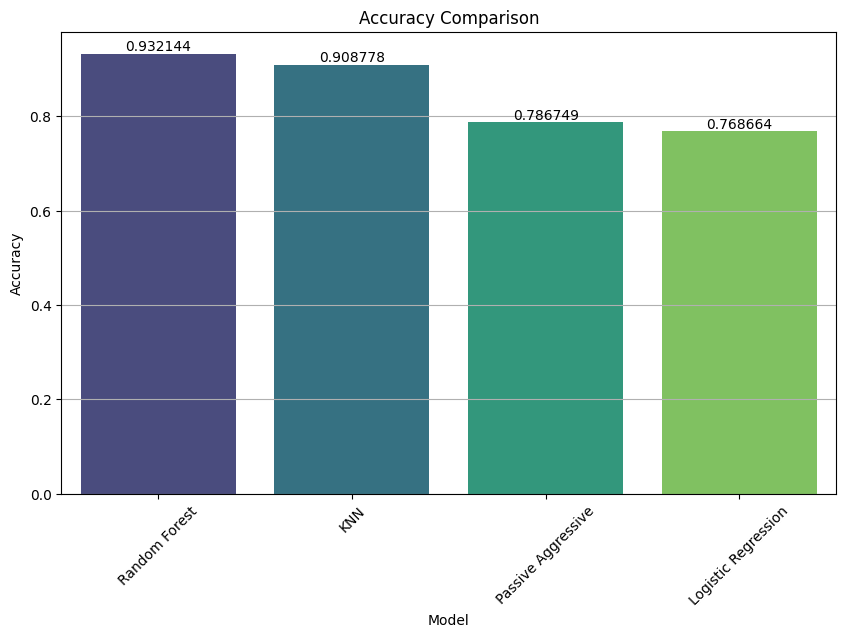

In [747]:
# Plot accuracy
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='Model', y='Accuracy', hue='Model', data=results_df, palette='viridis', dodge=False, legend=False)
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add values per bar
for container in ax2.containers:
    ax2.bar_label(container)
plt.show()

Show Confusion Matrix for each model

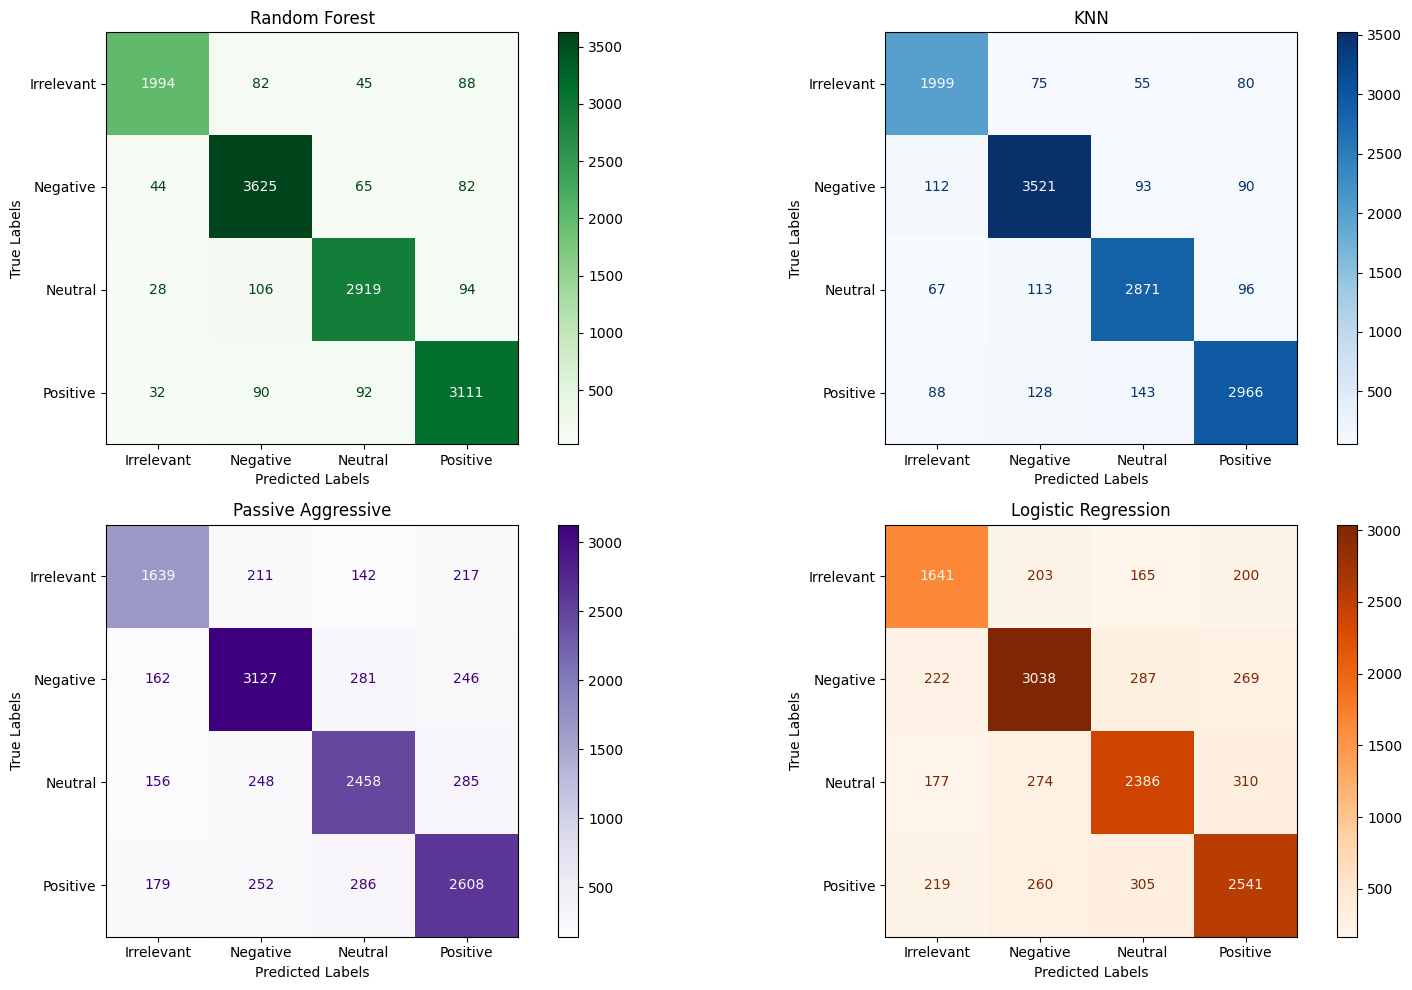

In [748]:
cmx_colors = ['Greens', 'Blues', 'Purples', 'Oranges']

def plot_confusion_matrices(models, model_names, X_test, y_test, colors):
    plt.figure(figsize=(16, 10)) 

    for i, (model, model_name, color) in enumerate(zip(models, model_names, colors), start=1):
        # Get predictions 
        y_pred = model.predict(X_test)

        # Calculate confusion matrix
        confusion = confusion_matrix(y_test, y_pred)
        cmx = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=['Irrelevant', 'Negative', 'Neutral', 'Positive'])

        # Subplot for current model
        plt.subplot(2, 2, i)

        # Plot confusion matrix with specified color scheme
        cmx.plot(cmap=color, ax=plt.gca())
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(model_name)

    plt.tight_layout()
    plt.show()


plot_confusion_matrices(models.values(), models.keys(), X_test, y_test, cmx_colors)

In [749]:
# Print summary of Precision and Training Time
print(results_df)

                 Model  Training Time (seconds)  Accuracy
0        Random Forest               110.281457  0.932144
1                  KNN                 0.003902  0.908778
2   Passive Aggressive                 1.798142  0.786749
3  Logistic Regression                18.476909  0.768664


# Conclusion

The <b>Random Forest model</b>, achieving the highest accuracy of <b>93.2%</b> means it could predict the sentiments of the tweets more accurately. However, it had the longest training time at <b>110.3 seconds</b>, indicating its need for more computational resources.

<b>K Nearest Neighbors (KNN)</b> algorithm, with a negligible training time of <b>0.004 seconds</b>, achieved an accuracy of <b>90.9%</b>. Its rapid training and competitive accuracy make it efficient for rapid model deployment or real-time predictions.

<b>Passive Aggressive</b> Classifier, trained in <b>1.80 seconds</b>, achieved an accuracy of <b>78.7%</b>. Despite its speed advantage over Random Forest, it falls short in accuracy, showing its limitations in precise sentiment prediction.

<b>Logistic Regression</b>, trained in <b>18.5 seconds</b>, performed with an accuracy of <b>76.9%</b>. This model lags behind in both accuracy and training time compared to the other models, suggesting it may not be the optimal choice for this sentiment analysis task.

<br>
In summary, <b>Random Forest</b> offers the highest accuracy among the models, making it suitable when precise sentiment prediction is critical, despite its longer training time. <b>K Nearest Neighbors (KNN)</b> stands out with very fast training and competitive accuracy, which means it is efficient for tasks that require a balance of both time and accuracy, such as rapid model deployment or real-time predictions.